In [ ]:
!pip install torchtext

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.notebook import trange, tqdm
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import torch
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModel

import pandas as pd
df = pd.read_parquet("hf://datasets/gimmaru/ag_news/data/test-00000-of-00001-6ad17b7a040f1d68.parquet")

torch.backends.cuda.matmul.allow_tf32 = True

In [59]:
df.head()

,text,label
0,Indian board plans own telecast of Australia s...,1
1,Stocks Higher on Drop in Jobless Claims A shar...,2
2,"Nuggets 112, Raptors 106 Carmelo Anthony score...",1
3,Stocks Higher on Drop in Jobless Claims A shar...,2
4,REVIEW: 'Half-Life 2' a Tech Masterpiece (AP) ...,3


In [61]:
device = torch.device(1 if torch.cuda.is_available() else 'cpu')

In [62]:
import random

toberead = list(df['text'])
random.shuffle(toberead)

In [63]:
model_name = "sentence-transformers/all-MiniLM-L6-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
base_model = AutoModel.from_pretrained(model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_model.to(device)

_ = base_model.eval()

In [64]:
from torch.utils.data import Dataset

class TextOnlyDataset(Dataset):
    def __init__(self, text_list):
        self.text_list = text_list

    def __len__(self):
        return len(self.text_list)

    def __getitem__(self, idx):
        return self.text_list[idx]


batch_size = 64
text_dataset = TextOnlyDataset(toberead)
text_loader = DataLoader(text_dataset, batch_size=batch_size, shuffle=False)


In [65]:
embeddings_log = []
text_log = []

for text in tqdm(text_loader, desc="Extracting", leave=False):
    encoded_input = tokenizer(text, padding=True, truncation=True, return_tensors='pt').to(device)

    with torch.cuda.amp.autocast():
        with torch.no_grad():
            embeddings = base_model(**encoded_input)[0][:, 0]
            norm_embeddings = torch.nn.functional.normalize(embeddings, p=2, dim=1)
            embeddings_log.append(norm_embeddings.cpu())
            text_log += list(text)


Extracting:   0%|          | 0/16 [00:00<?, ?it/s]

<ipython-input-65-e04e99253b47>:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.11/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


In [66]:
np_embeddings = torch.cat(embeddings_log).numpy()

In [67]:
print(np_embeddings.shape)

(1000, 384)


In [76]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

class PairDataset(Dataset):
    def __init__(self, pairs, pair_labels):
        self.pairs = pairs
        self.labels = pair_labels

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        x1, x2 = self.pairs[idx]
        label = self.labels[idx]
        return torch.tensor(x1).float(), torch.tensor(x2).float(), torch.tensor(label).float()

class SiameseNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, dropout_rate=0.05):
        super(SiameseNetwork, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )

    def forward_once(self, x):
        return self.encoder(x)

    def forward(self, x1, x2):
        out1 = self.forward_once(x1)
        out2 = self.forward_once(x2)
        return out1, out2

class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        distances = F.pairwise_distance(output1, output2)
        loss = (label * distances.pow(2) +
                (1 - label) * F.relu(self.margin - distances).pow(2)).mean()
        return loss

import random
from collections import defaultdict

def make_balanced_pairs(embeddings, pseudo_labels, num_pairs_per_class=1000):
    label_to_indices = defaultdict(list)
    for idx, label in enumerate(pseudo_labels):
        label_to_indices[label].append(idx)

    pairs = []
    pair_labels = []

    for label, indices in label_to_indices.items():
        if len(indices) < 2:
            continue
        for _ in range(num_pairs_per_class):
            i, j = random.sample(indices, 2)
            pairs.append((embeddings[i], embeddings[j]))
            pair_labels.append(1)

    labels = list(label_to_indices.keys())
    for _ in range(num_pairs_per_class * len(labels)):
        l1, l2 = random.sample(labels, 2)
        i = random.choice(label_to_indices[l1])
        j = random.choice(label_to_indices[l2])
        pairs.append((embeddings[i], embeddings[j]))
        pair_labels.append(0)

    return pairs, pair_labels

kmeans = KMeans(n_clusters=4, random_state=0)
pseudo_labels = kmeans.fit_predict(np_embeddings)
pairs, pair_labels = make_balanced_pairs(np_embeddings, pseudo_labels)

dataset = PairDataset(pairs, pair_labels)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

embedding_dim = np_embeddings.shape[-1]
model = SiameseNetwork(input_dim=embedding_dim)
criterion = ContrastiveLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 200
for epoch in range(num_epochs):
    total_loss = 0.0
    for batch_x1, batch_x2, batch_labels in dataloader:
        out1, out2 = model(batch_x1, batch_x2)
        loss = criterion(out1, out2, batch_labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

with torch.no_grad():
    improved_embeddings = model.forward_once(torch.tensor(np_embeddings).float()).numpy()


Epoch 10, Loss: 13.2107
Epoch 20, Loss: 11.4086
Epoch 30, Loss: 12.4654
Epoch 40, Loss: 11.6158
Epoch 50, Loss: 11.5465
Epoch 60, Loss: 11.4059
Epoch 70, Loss: 10.4120
Epoch 80, Loss: 11.1477
Epoch 90, Loss: 10.2938
Epoch 100, Loss: 11.0737
Epoch 110, Loss: 11.0226
Epoch 120, Loss: 11.3251
Epoch 130, Loss: 11.3837
Epoch 140, Loss: 11.1742
Epoch 150, Loss: 11.2914
Epoch 160, Loss: 10.2582
Epoch 170, Loss: 10.9735
Epoch 180, Loss: 10.8757
Epoch 190, Loss: 10.1656
Epoch 200, Loss: 10.2022


In [77]:
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters)
siamesed_cluster_labels = kmeans.fit_predict(improved_embeddings)
siamesed_cluster_centers = kmeans.cluster_centers_

In [78]:
pca = PCA(n_components=20)

combined_embs = np.vstack([improved_embeddings, siamesed_cluster_centers])
combined_pca = pca.fit_transform(combined_embs)

In [79]:
tsne = TSNE(n_components=2, perplexity=50)
combined_2d = tsne.fit_transform(combined_pca)

embeddings_2d = combined_2d[:-n_clusters]
centers_2d = combined_2d[-n_clusters:]

In [80]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

import numpy as np
if not isinstance(improved_embeddings, np.ndarray):
    improved_embeddings = improved_embeddings.cpu().numpy()

sil_score = silhouette_score(improved_embeddings, siamesed_cluster_labels)
db_index = davies_bouldin_score(improved_embeddings, siamesed_cluster_labels)
ch_index = calinski_harabasz_score(improved_embeddings, siamesed_cluster_labels)

print(f"Silhouette Score: {sil_score:.4f}")
print(f"Davies-Bouldin Index: {db_index:.4f}")
print(f"Calinski-Harabasz Index: {ch_index:.4f}")

Silhouette Score: 0.9252
Davies-Bouldin Index: 0.1382
Calinski-Harabasz Index: 9464.1357


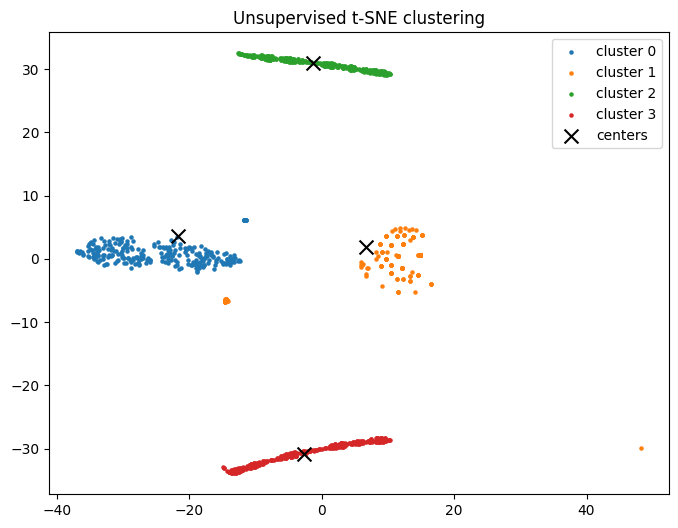

In [81]:
plt.figure(figsize=(8,6))
for c in range(n_clusters):
    idx = np.where(siamesed_cluster_labels == c)[0]
    plt.scatter(embeddings_2d[idx,0],
                embeddings_2d[idx,1],
                s=5, label=f"cluster {c}")

plt.scatter(centers_2d[:,0],
            centers_2d[:,1],
            marker="x", s=100, c="k", label="centers")
plt.legend()
plt.title("Unsupervised t-SNE clustering")
plt.show()